In [15]:
import pandas as pd
import numpy as np
import math
import pylab as plt
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

dataframe =  pd.read_csv('../data/Table_E.csv')

# A. DATASET SUMMARY
## 1. Peak into the data

In [2]:
print(dataframe.head(3))

              name                  address  zipcode  \
0          juniper           237 w 35th st,    10001   
1      izakaya mew  53 w 35th st, basement,    10001   
2  chelsea station             290 8th ave,    10001   

                          cuisine price  rating  review_count violation_code  \
0                   bars american    $$     4.0           180            06C   
1                   bars japanese    $$     4.0          1232            06C   
2  mediterranean italian american    $$     4.0            25            02G   

  critical_flag grade  median_household_income  median_real_estate_value  \
0      Critical     A                    81671                    650200   
1      Critical     B                    81671                    650200   
2      Critical     Z                    81671                    650200   

   population_density  cost_of_living  population         neighborhood  \
0               35350           157.4       21966  Chelsea and Clinton   
1

## 2. Statistics

In [3]:
print(dataframe.describe())

            zipcode       rating  review_count  median_household_income  \
count   5560.000000  5560.000000   5560.000000              5560.000000   
mean   10730.568525     3.596223    120.814568             64329.035971   
std      577.140012     0.732660    231.550470             28443.900208   
min    10001.000000     1.000000      1.000000             20232.000000   
25%    10029.000000     3.000000     14.000000             43398.000000   
50%    11105.000000     3.500000     49.000000             57525.000000   
75%    11229.000000     4.000000    138.000000             82332.000000   
max    11435.000000     5.000000   5147.000000            230952.000000   

       median_real_estate_value  population_density  cost_of_living  \
count              5.560000e+03         5560.000000     5560.000000   
mean               6.100510e+05        50517.521043      159.687680   
std                2.145011e+05        30005.150638        7.106094   
min                7.600000e+04         

## 3. Transforming string categorical variables to integers

In [4]:
le = preprocessing.LabelEncoder()
dataframe['violation_code'] = le.fit_transform(dataframe['violation_code'])
dataframe['price'] = le.fit_transform(dataframe['price'])
dataframe['critical_flag'] = le.fit_transform(dataframe['critical_flag'])
dataframe['grade'] = le.fit_transform(dataframe['grade'])
dataframe['neighborhood'] = le.fit_transform(dataframe['neighborhood'])
dataframe['borough'] = le.fit_transform(dataframe['borough'])
dataframe['rating'] = le.fit_transform(dataframe['rating'])

data = dataframe.values

## 2. Histogram Plot of attributes

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x114072278>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x117a10a90>]], dtype=object)

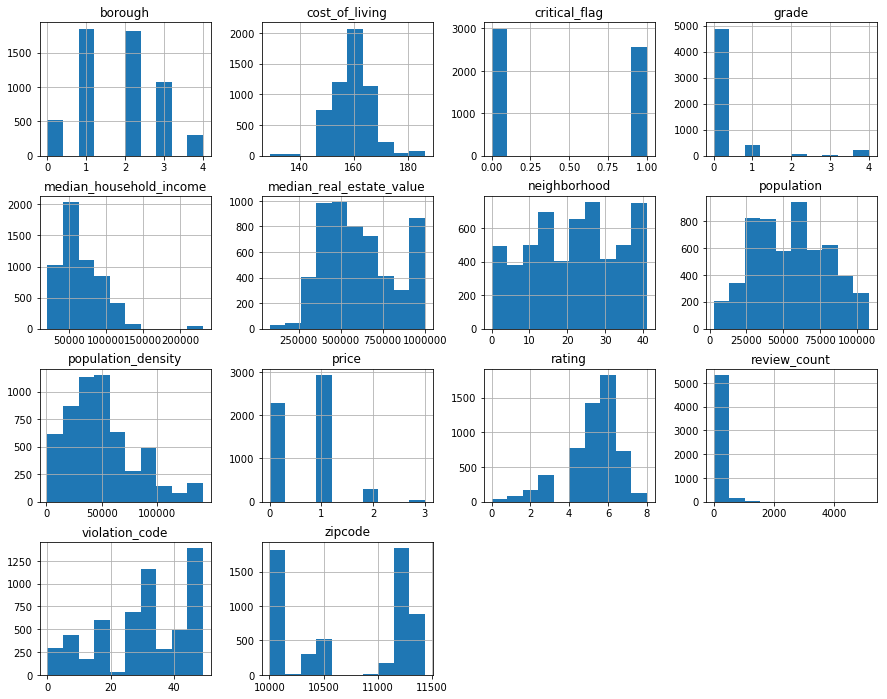

In [5]:
dataframe.hist(figsize=(15,12))

# B. CLASSIFICATION

In [6]:
# function that implements different classification algorithms
def classify(X,y,name):
    metric = 'accuracy'
    seed = 7

    # Set of all classification algorithms considered
    models = []
    models.append(('LR', LogisticRegression()))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('NB', GaussianNB()))
    models.append(('SVM', SVC()))

    # Cross-validation accuracy for different algorithms
    names = []
    performance = []
    for technique, model in models:
        k_fold = model_selection.KFold(n_splits=5, random_state=seed)
        cv_perf = model_selection.cross_val_score(model, X, y, cv=k_fold, scoring=metric)
        performance.append(cv_perf)
        names.append(technique)
        print("Technique:%s, Accuracy_mean: %f, Accuracy_std: %f)" % (technique, cv_perf.mean(), cv_perf.std()))


    # Comparison of the techniques
    plt.figure()
    plt.title(name)
    plt.boxplot(performance)
    plt.xticks(range(1,len(names)+1),names)
    plt.ylabel('Accuracy')
    plt.xlabel('Techniques')
    plt.show()

## 1. Predicting restaurant price from other attributes

Predicting restaurant price from other attributes
Unique classes of the labels in the data  [0 1 2 3]
Technique:LR, Accuracy_mean: 0.610612, Accuracy_std: 0.022608)
Technique:LDA, Accuracy_mean: 0.585971, Accuracy_std: 0.027096)
Technique:KNN, Accuracy_mean: 0.560971, Accuracy_std: 0.017133)
Technique:CART, Accuracy_mean: 0.521942, Accuracy_std: 0.027610)
Technique:NB, Accuracy_mean: 0.525000, Accuracy_std: 0.060672)
Technique:SVM, Accuracy_mean: 0.620324, Accuracy_std: 0.012322)


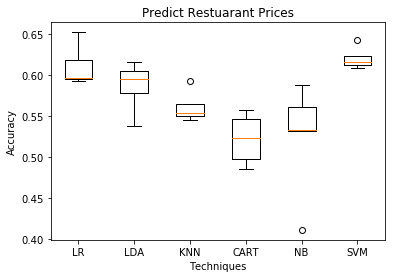

In [12]:
# Selection of the best classifier
feature_attrs = [2,5,6,7,8,9,10,11,12,13,14,15,16]
label_attrs = 4

print('Predicting restaurant price from other attributes')
print('Unique classes of the labels in the data ' , (np.unique(data[:,label_attrs])))
X = data[:,feature_attrs]
X_scaled = preprocessing.scale(X)
y = list(data[:,label_attrs])
classify(X_scaled,y,'Predict Restuarant Prices')

In [24]:
# Best classifier is chosen as logistic regression

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=0)

# Set the parameters by cross-validation
tuned_parameters = [{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }]

scores = ['accuracy','precision_macro', 'recall_macro']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    clf = GridSearchCV(LogisticRegression(penalty='l2'), tuned_parameters, cv=5, scoring='%s' % score)
    clf.fit(X_train, y_train)
    print()
    print("Grid scores for the best parameter on development set:")
    print("%0.3f (+/-%0.03f) for %r" % (clf.cv_results_['mean_test_score'][clf.best_index_], clf.cv_results_['std_test_score'][clf.best_index_], clf.cv_results_['params'][clf.best_index_]))

    print("Classification report:")
    print()
    print("The model is trained on the training set.")
    print("The scores are computed on the test set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()


# Tuning hyper-parameters for accuracy


Grid scores for the best parameter on development set:
0.664 (+/-0.013) for {'C': 0.001}
Classification report:

The model is trained on the training set.
The scores are computed on the test set.

             precision    recall  f1-score   support

          0       0.59      0.70      0.64      1813
          1       0.67      0.65      0.66      2361
          2       0.00      0.00      0.00       233
          3       0.00      0.00      0.00        41

avg / total       0.60      0.63      0.61      4448


# Tuning hyper-parameters for precision_macro


Grid scores for the best parameter on development set:
0.334 (+/-0.007) for {'C': 0.001}
Classification report:

The model is trained on the training set.
The scores are computed on the test set.

             precision    recall  f1-score   support

          0       0.59      0.70      0.64      1813
          1       0.67      0.65      0.66      2361
          2       0.00      0.00   

## 2. Predicting restaurant rating from other attributes

Predicting restaurant price from other attributes
Unique classes of the labels in the data  [0 1 2 3 4 5 6 7 8]
Technique:LR, Accuracy_mean: 0.318165, Accuracy_std: 0.068154)
Technique:LDA, Accuracy_mean: 0.318705, Accuracy_std: 0.066514)
Technique:KNN, Accuracy_mean: 0.253237, Accuracy_std: 0.042844)
Technique:CART, Accuracy_mean: 0.215468, Accuracy_std: 0.013309)
Technique:NB, Accuracy_mean: 0.207374, Accuracy_std: 0.075341)
Technique:SVM, Accuracy_mean: 0.297842, Accuracy_std: 0.032256)


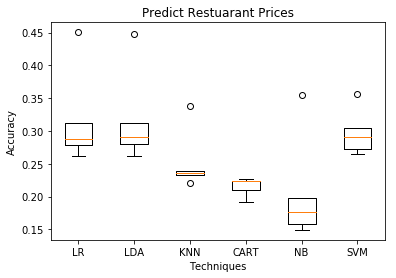

In [8]:
feature_attrs = [2,4,6,7,8,9,10,11,12,13,14,15,16]
label_attrs = 5

print('Predicting restaurant price from other attributes')
print('Unique classes of the labels in the data ' , (np.unique(data[:,label_attrs])))
X = data[:,feature_attrs]
X_scaled = preprocessing.scale(X)
y = list(data[:,label_attrs])
classify(X_scaled,y,'Predict Restuarant Prices')

## 3. Predicting critical flag from other attributes

Predicting restaurant price from other attributes
Unique classes of the labels in the data  [0 1]
Technique:LR, Accuracy_mean: 0.999101, Accuracy_std: 0.000804)
Technique:LDA, Accuracy_mean: 0.963309, Accuracy_std: 0.019491)
Technique:KNN, Accuracy_mean: 0.880216, Accuracy_std: 0.017114)
Technique:CART, Accuracy_mean: 1.000000, Accuracy_std: 0.000000)
Technique:NB, Accuracy_mean: 0.958453, Accuracy_std: 0.022184)
Technique:SVM, Accuracy_mean: 0.967626, Accuracy_std: 0.013302)


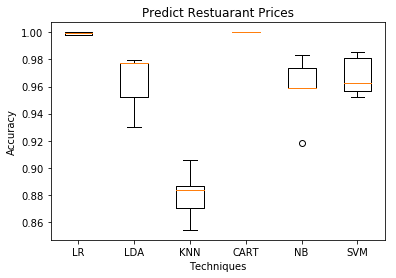

In [9]:
feature_attrs = [2,5,6,7,4,9,10,11,12,13,14,15,16]
label_attrs = 8

print('Predicting restaurant price from other attributes')
print('Unique classes of the labels in the data ' , (np.unique(data[:,label_attrs])))
X = data[:,feature_attrs]
X_scaled = preprocessing.scale(X)
y = list(data[:,label_attrs])
classify(X_scaled,y,'Predict Restuarant Prices')

## 4. Predicting borough from other attributes

Predicting restaurant price from other attributes
Unique classes of the labels in the data  [0 1 2 3 4]
Technique:LR, Accuracy_mean: 0.635791, Accuracy_std: 0.223675)
Technique:LDA, Accuracy_mean: 0.721223, Accuracy_std: 0.274816)
Technique:KNN, Accuracy_mean: 0.611691, Accuracy_std: 0.146674)
Technique:CART, Accuracy_mean: 0.700540, Accuracy_std: 0.299185)
Technique:NB, Accuracy_mean: 0.834173, Accuracy_std: 0.126293)
Technique:SVM, Accuracy_mean: 0.636871, Accuracy_std: 0.198659)


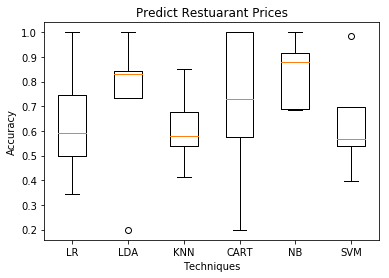

In [10]:
feature_attrs = [2,5,6,7,4,9,10,11,12,13,14,15,8]
label_attrs = 16

print('Predicting restaurant price from other attributes')
print('Unique classes of the labels in the data ' , (np.unique(data[:,label_attrs])))
X = data[:,feature_attrs]
X_scaled = preprocessing.scale(X)
y = list(data[:,label_attrs])
classify(X_scaled,y,'Predict Restuarant Prices')